# MNIST

Fetch MNIST Dataset

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)

mnist.keys()

/home/kratosgado/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

reshape instance's feature vector to 28x28 array and display it

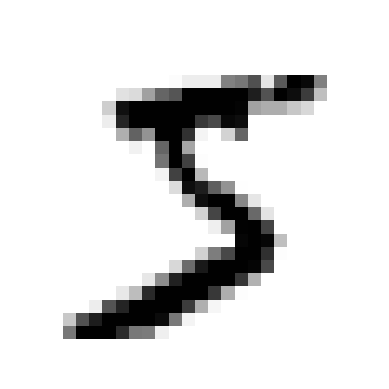

In [6]:
import matplotlib as mpl 
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap= mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [7]:
y[0]

'5'

In [8]:
import numpy as np
y = y.astype(np.uint8)

split train set

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Training a Binary Classifier

In [11]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

### SGDClassifier

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [13]:
sgd_clf.predict([some_digit])

array([ True])

#### Measuring Accuracy Using Cross-Validation

In [14]:
# custom cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
   clone_clf = clone(sgd_clf)
   X_train_folds = X_train[train_index]
   y_train_folds = y_train_5[train_index]
   X_test_fold = X_train[test_index]
   y_test_fold = y_train_5[test_index]

   clone_clf.fit(X_train_folds, y_train_folds)
   y_pred = clone_clf.predict(X_test_fold)
   n_correct = sum(y_pred == y_test_fold)
   print(n_correct / len(y_pred)) 

0.95035
0.96035
0.9604


In [15]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=5, scoring="accuracy")

array([0.95466667, 0.96975   , 0.9635    , 0.96533333, 0.94841667])

In [16]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
   
   def fit(self, X, y=None):
      pass

   def predict(self, X):
      return np.zeros((len(X), 1), dtype=bool)
   
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=5, scoring="accuracy")

array([0.91266667, 0.90866667, 0.9095    , 0.90883333, 0.90858333])

In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=5)

get confusion matrix

In [18]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53115,  1464],
       [  916,  4505]])

In [19]:
y_train_perfect_predictions  = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision and Recall

In [20]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred) 


0.7547327860613168

In [21]:
recall_score(y_train_5, y_train_pred)

0.8310274857037447

Harmonic Mean(F1 Score)

In [22]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.791044776119403

## Precision/Recall Tradeoff

In [23]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [24]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [25]:
threshold = 8000 # raise threshold
y_some_digit_pred = y_scores > threshold
y_some_digit_pred

array([False])

In [26]:
y_scores = cross_val_predict(sgd_clf, X_train,y_train_5, cv=3, method="decision_function")

In [27]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

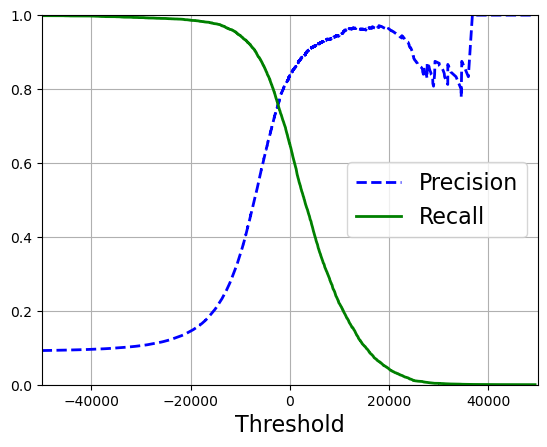

In [28]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [31]:
# aiming for 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [32]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [34]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [35]:
recall_score(y_train_5, y_train_pred_90)


0.4799852425751706